In [312]:
import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from python_speech_features import mfcc
from sklearn.preprocessing import StandardScaler
from scipy.signal import lfilter


# Filename identifiers

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [313]:
emotion_labels = {
    "01": 'neutral',
    "02": 'calm',
    "03": 'happy',
    "04": 'sad',
    "05": 'angry',
    "06": 'fearful',
    "07": 'disgust',
    "08": 'surprised'
}


def load_data(dataset_path):
    emotions = []
    features = []
    for file in glob.glob(dataset_path + 'Actor_*/*.wav'):
        emotions.append(extract_emotion_from_filename(os.path.basename(file)))
        features.append(extract_features(file))
    return np.array(features), np.array(emotions)

def extract_mfcc(audio, sample_rate):
    frame_len = int(2 ** np.floor(np.log2(0.03 * sample_rate)))
    mfccs = mfcc(audio, 
                 sample_rate, 
                 winlen=frame_len / sample_rate, 
                 winstep=frame_len / (2 * sample_rate), 
                 preemph=0.97,
                 numcep=12,
                 winfunc=numpy.hamming)
    return np.mean(mfccs, axis=0)

def extract_emotion_from_filename(filename):
    emotion_code = filename.split('-')[2]
    return emotion_labels[emotion_code]

def pre_empasize(audio, alpha=0.97):
    return lfilter([1, -alpha], 1, audio)

def get_stft(audio):
    return np.abs(librosa.stft(audio))

def get_mffc(audio, sample_rate):
    return np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T,axis=0)

def get_chroma(stft, sample_rate):
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

def get_mel(audio, sample_rate):
    return np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T,axis=0)

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)
    
    audio = pre_empasize(audio)
    stft = get_stft(audio)

    result=np.array([])

    mfccs = get_mffc(audio, sample_rate)
    result=np.hstack((result, mfccs))

    chroma = get_chroma(stft, sample_rate)
    result=np.hstack((result, chroma))

    mel = get_mel(audio, sample_rate)
    result=np.hstack((result, mel))
    
    return result

    """
    features = np.array([])

    mfcc = extract_mfcc(audio, sample_rate)

    features = np.concatenate([mfcc])
    return features"""

In [314]:
dataset_path = 'ravdess/'
features, emotions = load_data(dataset_path)

In [315]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features, emotions, test_size=0.2, random_state=42)

print(f'{len(X_train)} samples in training set')
print(f'{len(X_test)} samples in testing set')

"""
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'linear']
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(SVC(), param_grid, n_jobs=-1, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)


grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=2)
grid_search_knn.fit(X_train, y_train)

print(grid.best_params_)
print(grid_search_rf.best_params_)
print(grid_search_knn.best_params_)"""

1152 samples in training set
288 samples in testing set


"\nparam_grid = {\n    'C': [0.1, 1, 10, 100],\n    'gamma': [1, 0.1, 0.01, 0.001],\n    'kernel': ['rbf', 'poly', 'linear']\n}\n\nparam_grid_rf = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [None, 10, 20, 30],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'bootstrap': [True, False]\n}\n\nparam_grid_knn = {\n    'n_neighbors': [3, 5, 7, 9],\n    'weights': ['uniform', 'distance'],\n    'metric': ['euclidean', 'manhattan', 'minkowski']\n}\n\ngrid = GridSearchCV(SVC(), param_grid, n_jobs=-1, refit=True, verbose=2, cv=5)\ngrid.fit(X_train, y_train)\n\ngrid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)\ngrid_search_rf.fit(X_train, y_train)\n\n\ngrid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=2)\ngrid_search_knn.fit(X_train, y_train)\n\nprint(grid.best_params_)\nprint(grid_search_rf.best_params_)\nprint(grid_search_knn.best_para

In [316]:

classifiers = {
    'SVM': SVC(kernel='rbf', C=10, gamma=0.01),
    'Random Forest': RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300),
    'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
}

results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

Results for SVM:
Accuracy: 0.6770833333333334
Precision: 0.687201057480243
Recall: 0.6770833333333334
F1 Score: 0.6764638531727748
Confusion Matrix:


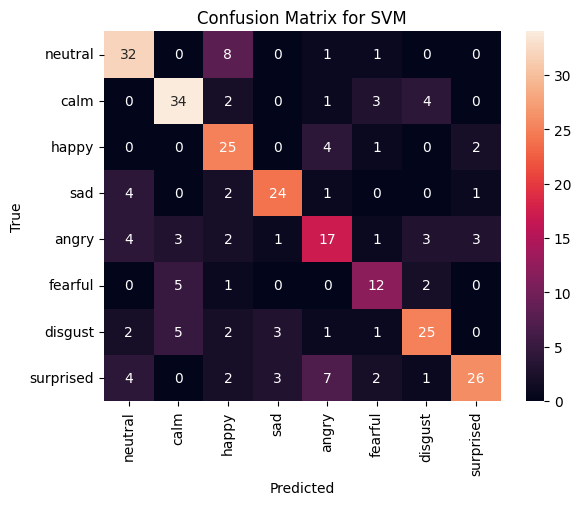

Results for Random Forest:
Accuracy: 0.5868055555555556
Precision: 0.6158376601763087
Recall: 0.5868055555555556
F1 Score: 0.5786918450042667
Confusion Matrix:


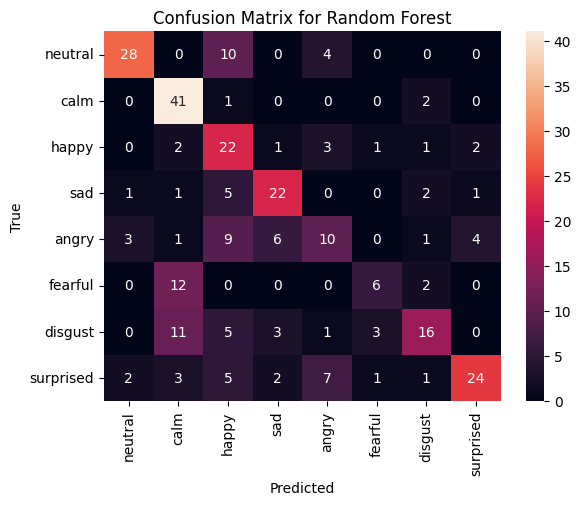

Results for KNN:
Accuracy: 0.6666666666666666
Precision: 0.6856783776918906
Recall: 0.6666666666666666
F1 Score: 0.6686184219535571
Confusion Matrix:


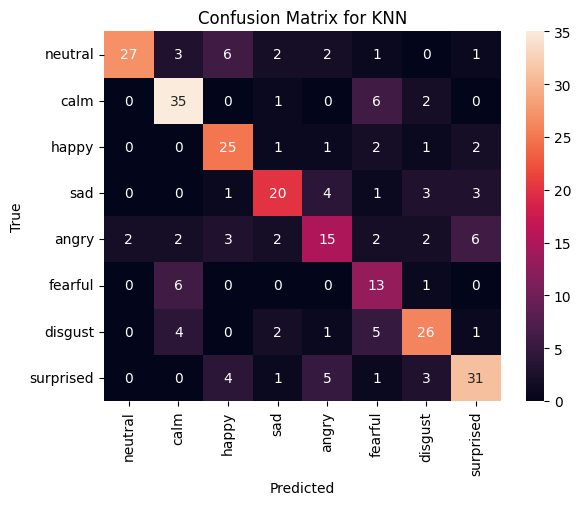

In [317]:
emotion_labels_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

for name, metrics in results.items():
    print(f"Results for {name}:")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1_score']}")
    print("Confusion Matrix:")
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', xticklabels=emotion_labels_list, yticklabels=emotion_labels_list)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()